**Câu 4: Clustering - CBC News Coronavirus articles (1.0 điểm)**
<br>Build a clustering model to **cluster the articles** in **cbc-news-coronavirus-articles-march-26** dataset? Explain the main characteristics of each cluster. Use Word Cloud
to visualize each cluster.
<br>(Hint: Use feature description and/or text)
<br>Read more information here:
<br>https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26

In [ ]:
#@title Install Pakages
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [ ]:
#@title Mount ot drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/LDS9_K269_ONLINE_NgoThiNga/LDS9_K269_NgoThiNga_Cuoi_ky/Du lieu cung cap/cbc-news-coronavirus-articles-march-26'

/content/gdrive/MyDrive/LDS9_K269_ONLINE_NgoThiNga/LDS9_K269_NgoThiNga_Cuoi_ky/Du lieu cung cap/cbc-news-coronavirus-articles-march-26


In [ ]:
#@title Import pakages
import pyspark
import pandas as pd
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, explode
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.sql.functions import isnan,concat,monotonically_increasing_id, count, regexp_replace, regexp_extract, col, datediff, when, length, log, array, lit, trim
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime

from pyspark.ml.feature import Binarizer,Bucketizer, OneHotEncoder, StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import LinearSVC, LinearSVCModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName('Cau4').getOrCreate()

In [ ]:
# Loads data.
data = spark.read.csv("news.csv", header=True,
                      inferSchema=True)

In [ ]:
df = data.select('authors','title','description','text')
df.show(3)

+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|         description|                text|
+--------------------+--------------------+--------------------+--------------------+
|        ['Cbc News']|Coronavirus a 'wa...|Canadian pharmaci...|"Canadian pharmac...|
|        ['Cbc News']|Yukon gov't names...|The Yukon governm...|"The Yukon govern...|
|['The Associated ...|U.S. Senate passe...|The Senate has pa...|"The Senate late ...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
df.count()

3566

In [ ]:
df.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
authors,0
title,0
description,0
text,0


In [ ]:
# => không có dữ liệu null

**Kết hợp dữ liệu text trên các cột title, description, text**

In [ ]:
df_new = df.select("title","description","text")
df_new = df_new.select(concat(col("title"), lit(" "), col("description"),lit(" "), col("text")).alias('summary_text'))
df_new = df_new.withColumn("summary_clean", regexp_replace(col("summary_text"), "[^a-zA-Z]", " "))
df_new.show(5)

+--------------------+--------------------+
|        summary_text|       summary_clean|
+--------------------+--------------------+
|Coronavirus a 'wa...|Coronavirus a  wa...|
|Yukon gov't names...|Yukon gov t names...|
|U.S. Senate passe...|U S  Senate passe...|
|Coronavirus: The ...|Coronavirus  The ...|
|The latest on the...|The latest on the...|
+--------------------+--------------------+
only showing top 5 rows



## Chuẩn hóa chuỗi trên summary_clean column

In [ ]:
# Chuẩn hóa dữ liệu 'summary_clean'
from pyspark.ml.feature import Tokenizer, StopWordsRemover 
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer 
tokenizer = Tokenizer(inputCol='summary_clean', outputCol='token_text')
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='cv')
idf = IDF(inputCol='cv', outputCol='tf-idf')


In [ ]:
clean_up = VectorAssembler(inputCols=['tf-idf'], outputCol='features')

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up])

In [ ]:
cleaner = data_prep_pipe.fit(df_new)

In [ ]:
cleaner_data = cleaner.transform(df_new)

In [ ]:
cleaner_data.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        summary_text|       summary_clean|          token_text|         stop_tokens|                  cv|              tf-idf|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Coronavirus a 'wa...|Coronavirus a  wa...|[coronavirus, a, ...|[coronavirus, , w...|(16510,[0,1,3,4,5...|(16510,[0,1,3,4,5...|(16510,[1,3,4,5,8...|
|Yukon gov't names...|Yukon gov t names...|[yukon, gov, t, n...|[yukon, gov, name...|(16510,[0,1,3,4,5...|(16510,[0,1,3,4,5...|(16510,[1,3,4,5,1...|
|U.S. Senate passe...|U S  Senate passe...|[u, s, , senate, ...|[u, , senate, pas...|(16510,[0,2,3,11,...|(16510,[0,2,3,11,...|(16510,[2,3,11,23...|
|Coronavirus: The ...|Coronavirus  The ...|[coronavirus, , t...|[coronavirus, , l...|(16510,[0,1,2,3,5...|

## PCA

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=3, inputCol='features', outputCol='features_pca')

In [ ]:
pca_fit = pca.fit(cleaner_data)

In [ ]:
# pca_fit.explainedVariance

In [ ]:
# pca_data = pca_fit.transform(cleaner_data).select('features_pca')

In [ ]:
# pca_data.show(3, truncate=False)

## Áp dụng Clustering model

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
# Train a k-means model
k_list = []
wsse_list = []
silhouette_list = []

wsse_str = ""
sil_str = ""


for k in range(2,7):
  kmeans = KMeans(featuresCol='features', k=k)
  model = kmeans.fit(cleaner_data)
  # wsse
  wsse = model.computeCost(cleaner_data)
  k_list.append(k)
  wsse_list.append(wsse)

  # silhoutte
  predictions = model.transform(cleaner_data)
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)
  silhouette_list.append(silhouette)

  wsse_str = wsse_str + "With k =" + str(k) + " - Set Sum of Squared Errors = " + str(wsse) + "\n"
  sil_str = sil_str + "With k =" + str(k) + " - Silhouette = " + str(silhouette) + "\n"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

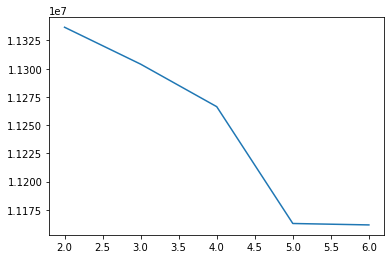

In [ ]:
plt.plot(k_list, wsse_list)

In [ ]:
print(wsse_str)

With k =2 - Set Sum of Squared Errors = 11336688.368418496
With k =3 - Set Sum of Squared Errors = 11303995.070765454
With k =4 - Set Sum of Squared Errors = 11266339.984471746
With k =5 - Set Sum of Squared Errors = 11162868.213716466
With k =6 - Set Sum of Squared Errors = 11161607.96124835



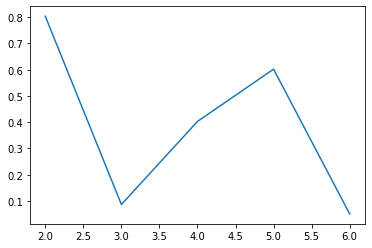

In [ ]:
plt.plot(k_list, silhouette_list)
plt.show()

In [ ]:
print(sil_str)

With k =2 - Silhouette = 0.8038349574835595
With k =3 - Silhouette = 0.08642519600441435
With k =4 - Silhouette = 0.40298104803926416
With k =5 - Silhouette = 0.6022468319735418
With k =6 - Silhouette = 0.05054575176896664



**Áp dụng model cho giá trị k dc chọn: k=4**

In [ ]:
# train a k-means model
kmeans = KMeans(featuresCol='features', k=4)
model = kmeans.fit(cleaner_data)

In [ ]:
# Tính Silhouette
predictions = model.transform(cleaner_data)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette = " + str(silhouette))

Silhouette = 0.40298104803926416


In [ ]:
predictions.select("prediction").show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [ ]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  183|
|         3|    2|
|         2|    2|
|         0| 3379|
+----------+-----+



In [ ]:
predictions.select('summary_clean','features','prediction').show(10)

+--------------------+--------------------+----------+
|       summary_clean|            features|prediction|
+--------------------+--------------------+----------+
|Coronavirus a  wa...|(16510,[1,3,4,5,8...|         0|
|Yukon gov t names...|(16510,[1,3,4,5,1...|         0|
|U S  Senate passe...|(16510,[2,3,11,23...|         0|
|Coronavirus  The ...|(16510,[1,2,3,5,7...|         0|
|The latest on the...|(16510,[1,3,4,6,7...|         0|
| Worse  pandemic ...|(16510,[11,15,41,...|         0|
|What you need to ...|(16510,[1,2,3,4,5...|         1|
|Michigan hospital...|(16510,[1,2,3,4,5...|         0|
|U S  coronavirus ...|(16510,[1,3,4,5,6...|         0|
| Avoid the emerge...|(16510,[1,2,4,5,1...|         0|
+--------------------+--------------------+----------+
only showing top 10 rows



## WordCloud trên các Clustering

In [ ]:
# Clustering 1

In [ ]:
class_0 = predictions.select('summary_clean','features','prediction').filter(predictions.prediction==0)
class_0 = class_0.toPandas()
class_0.head()

,summary_clean,features,prediction
0,Coronavirus a wake up call for Canada s pres...,"(0.0, 1.1441026695873115, 0.0, 0.7247602359948...",0
1,Yukon gov t names possible sources of corona...,"(0.0, 0.3813675565291038, 0.0, 2.1742807079846...",0
2,U S Senate passes T coronavirus relief pack...,"(0.0, 0.0, 1.6324011967917063, 2.1742807079846...",0
3,Coronavirus The latest in drug treatment and ...,"(0.0, 1.5254702261164153, 0.8162005983958531, ...",0
4,The latest on the coronavirus outbreak for Mar...,"(0.0, 0.7627351130582076, 0.0, 2.8990409439795...",0


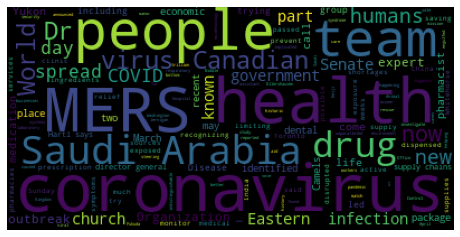

In [ ]:
text = class_0['summary_clean'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(8,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Clustering 2

In [ ]:
class_1 = predictions.select('summary_clean','features','prediction').filter(predictions.prediction==1)
class_1 = class_1.toPandas()
class_1.head()

,summary_clean,features,prediction
0,What you need to know about COVID in Ottawa...,"(0.0, 8.390086243640283, 19.588814361500475, 4...",1
1,From shopping to walks Your coronavirus quest...,"(0.0, 3.432308008761934, 3.2648023935834125, 0...",1
2,China to lift coronavirus lockdown in most of ...,"(0.0, 0.3813675565291038, 0.8162005983958531, ...",1
3,Coronavirus What s happening in Canada and ar...,"(0.0, 3.0509404522328305, 3.2648023935834125, ...",1
4,A COVID glossary What the terms mean and s...,"(0.0, 2.669572895703727, 4.897203590375119, 5....",1


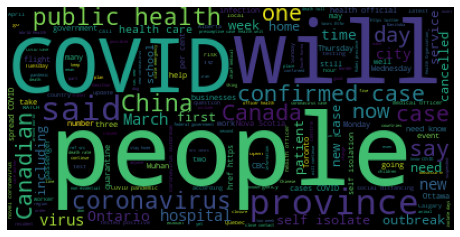

In [ ]:
text = class_1['summary_clean'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(8,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Clustering 3

In [ ]:
class_2 = predictions.select('summary_clean','features','prediction').filter(predictions.prediction==2)
class_2 = class_2.toPandas()
class_2.head()

,summary_clean,features,prediction
0,Counterfeit crackdown cannabis costs CBC s M...,"(0.0, 0.0, 2.4486017951875594, 0.0, 0.0, 0.0, ...",2
1,Counterfeit crackdown cannabis costs CBC s M...,"(0.0, 0.0, 2.4486017951875594, 0.0, 0.0, 0.0, ...",2


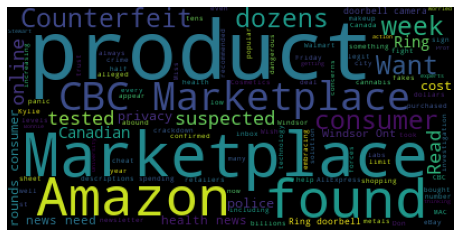

In [ ]:
text = class_2['summary_clean'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(8,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Clustering 4

In [ ]:
class_3 = predictions.select('summary_clean','features','prediction').filter(predictions.prediction==3)
class_3 = class_3.toPandas()
class_3.head()

,summary_clean,features,prediction
0,Iran s hardliners take early lead in Tehran in...,"(0.0, 0.0, 0.8162005983958531, 2.1742807079846...",3
1,Iran s hardliners take early lead in Tehran in...,"(0.0, 0.0, 0.8162005983958531, 2.1742807079846...",3


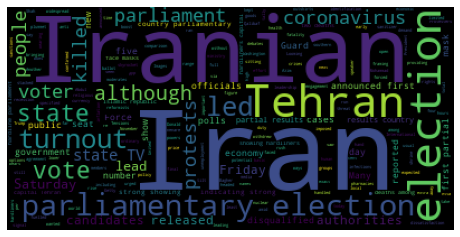

In [ ]:
text = class_3['summary_clean'].values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(8,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()